In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np

# random varaible values and parameter values
df = pd.read_csv('azdiabetes.csv')
X = df[['npreg', 'bp', 'bmi', 'ped', 'age']]
X = (X - X.mean()) / X.std()  # centering and scaling
X['intercept'] = 1
X = X.values
y = df['diabetes'].replace({'Yes': 1, 'No': 0})

/var/folders/dz/lgsl3l_d7fv4z40yrx07rfz80000gn/T/ipykernel_24197/3288299399.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['diabetes'].replace({'Yes': 1, 'No': 0})


In [2]:
from sampler import GibbsSampler

g = len(y)
nu0 = 2
sigma02 = 1

beta_GS, z_GS = GibbsSampler(y, X, g, nu0, sigma02).run_sampler()


In [2]:
from sampler import MetropolisHastingsSampler

mean_beta = np.zeros(6)
cov_beta = np.array([16, 4, 4, 4, 4, 4])
# Likelihood function
def likelihood(x):
    return np.exp(x) / (1 + np.exp(x))

beta_MH, z_MH = MetropolisHastingsSampler(y, X, likelihood, mean_beta, cov_beta).run_sampler()

1.0 [0.02493389        nan        nan        nan        nan        nan] -0.0 [0.02493389        nan        nan        nan        nan        nan] nan nan
[-2.69152726         nan         nan         nan         nan         nan]


/Users/cherylshi/UROP/PoP_venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    x        float64 8B 6.377


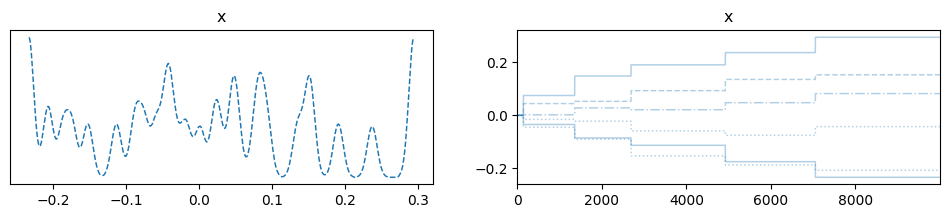

In [9]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

betadata_MH = az.convert_to_dataset(beta_MH.T)

az.plot_trace(betadata_MH, combined=True, compact=True)
print(az.ess(betadata_MH))  # ess should be as large as possible

plt.show()

In [5]:
from sampler import PolyaGamma

beta_PG, z_PG = PolyaGamma(y, X, likelihood, mean_beta, cov_beta).run_sampler()

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    x        float64 8B 7.182


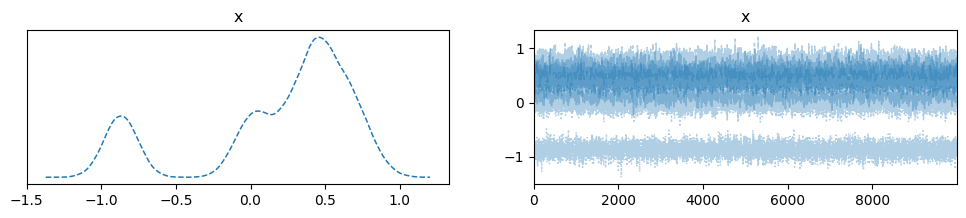

In [10]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

betadata_PG = az.convert_to_dataset(beta_PG.T)

az.plot_trace(betadata_PG, combined=True, compact=True)
print(az.ess(betadata_PG))

plt.show()

In [19]:
beta_GS * z_GS

array([[-0.00674357,  0.        ,  0.00936376, -0.0037442 , -0.00972509,
         0.00737131],
       [ 0.00790243,  0.        , -0.01207477, -0.01408796, -0.00165684,
         0.01894014],
       [-0.01551933,  0.        , -0.00141904,  0.00525909,  0.00862776,
        -0.01327625],
       ...,
       [ 0.00889219,  0.        , -0.01118855,  0.02665227, -0.0157278 ,
         0.00174712],
       [ 0.00876418,  0.        ,  0.00976291,  0.00771981,  0.00705738,
        -0.0019656 ],
       [ 0.02227893,  0.        , -0.00348191,  0.01165224, -0.01045126,
         0.00584959]])

In [30]:
sum(beta_GS[1]*z_GS[1]*X[1])

0.05122105393671954

In [27]:
z_GS[1]

array([1., 0., 1., 1., 1., 1.])

In [26]:
X[1]

array([ 1.05164402, -0.12230772, -1.13211776, -0.98670691,  2.17303872,
        1.        ])